# Deep Q Mountain Car
---
In this game, the agent is an underpowered car.\
It can't generate enough torque to get moving, but not climb the hill.\
The object is for the agent to learn to use both hills and momentum to reach the goal. 

### Pip Requirements
```
pip install gymnasium torch numpy torchmetrics
```

The first thing like always is to install any packages we'll use, if not already installed.\
Two new ones I used here are matplotlib and torchmetrics.\
These were both used to help better visualize our agents results.

### Imports

In [1]:
import random # Used to generate random float values, or make random choices from an array
import numpy as np # Used for data conversion, extraction, and manipulation
import gymnasium as gym # Provides us an environment and task for the agent
import torch # Pytorch
import torch.nn as nn # Neural Network, used to build the Network
import torch.optim as optim # Provides optimizer function to maximize preformance of the model
import torch.nn.functional as F # Gives us .mse_loss, calculate the loss ( diff between Pred and Trag ) and then rectifier function
from torchmetrics.classification import MulticlassAccuracy # This compares the predicted probabilities to the target result 
import matplotlib.pyplot as plt # We use this to plot the loss and accurracy on a graph

### Hyper Parameters
To Change the way the agent learns make changes in the cell below.\
This will affect the agent and evironment accordingly.

In [2]:
episodes = 50 # The number of time the agent will play the game

capacity = 100000 # The total size of the agents memory 100,000
sample_size = 50 # Number experiences used to train the agent per training iteration or EPOCH

learning_rate = .000011 # Also known as Alpha, this is used for model optimization and to calculate Q-Values
discount_factor = 0.98 # A.K.A. Gamma, when learning, this determins the weight of future Q-values when calculation current Q-value
interpolation_parameter = 1e-3 # This determins the weights of both the local and target networks when updating the Target Network.

epsilon_start = 1.0 # The probability the agent will experience a random event despite its outcome 1.0 is 100%
epsilon_end = 0.1 # This is the final probability for random events
epsilon_decay_rate = 1.2 / episodes # This is the amount removed from esilon decrease the random events and increasing the agents involvment.

### Non Learning Related Variables
If you would like to create a new model and not overwrite an existing one, change FILE variable.

In [3]:
FILE = './models/DQN_mountain_car(x).pth' # The desired path for your saved model

loss_hist = [] # Store agents loss history for plotting later
acc_hist = [] # Store agents accuracy history for plotting later
score_hist = [] # Store agents accuracy history for plotting later

### Agents Environment

In [4]:
env = gym.make("MountainCar-v0", render_mode=None)

state_size = env.observation_space.shape[0] # We call shape on the first element in the observation space to get the number of input features
action_size = env.action_space.n # Action space .n will give us the available number of actions, or outputs

### Artifical Neural Network
Here we can add/remove layers and nerons to the network to alter the preformance of the agent.\
If we add/remove layers, make sure we add/remove them from the forward method also.

In [5]:
class Network(nn.Module): # Our Network Module will inherit the torch.nn.Module / which gives use prebuilt training tools 
    def __init__(self, state_size, action_size, seed=42):
        super(Network, self).__init__() # nn.Module has multiple parent classes, we pass Network as a param to ensure we inherit all methods correctly
        self.seed = seed # Seed is like a set starting point for all the random adjustment the model will make during training (Doesn't have to be 42)
        self.fc1 = nn.Linear(state_size, 640) # As we are building an ANN we will use the Linear layers
        self.fc2 = nn.Linear(640,1228) # the first argument is the # of neurons in the first layer and the second is the following layers neurons
        self.fc3 = nn.Linear(1228,1228) # Note that the first argument matches the second argument of the previous layer
        self.fc4 = nn.Linear(1228,640) # This is becuase the are "fully onnected" layers
        self.fc5 = nn.Linear(640, action_size) # Also see that the state_size and action_size are first and last as the are inputs and ouputs.

    def forward(self, state): # This is forward propagation / where we will pass the observation through the model
        x = F.relu(self.fc1(state)) # We will pass the observation through every layer
        x = F.relu(self.fc2(x)) # Using the Rectifier Activation Fucntion, which basically turns neg outputs to 0
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x) # The raw output layer is returned so not to alter the models probablilities

### Replay Memory
In order for a neural network to learn, we will need large amounts of already existing data containing both input and output values.\
Since in this case the agent will learn from its own experiences, we will need to store each experience for later training.

In [6]:
class Memory(object):
    def __init__(self, capacity):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu") # Checks machine for GPU to storage, otherwise uses cpu
        self.capacity = capacity # number of events to store
        self.memory = [] # array to store each event

    def push(self, event):
        self.memory.append(event) # adds event to memory
        if len(self.memory) > self.capacity:
            del self.memory[0] # deletes oldest memory exceeds allocated size

    def sample(self, sample_size):
        experiences = random.sample(self.memory, sample_size) # random.sample(list, num_of_els) / grabs random elements from a list
        # The next 5 lines puts each element into its own list and converts that list into a torch tensor
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device) # .to(self.device) is
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device) # placing tensor in the 
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device) # location determined 
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device) # above
        terminations = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        # We then return each new tensor, NOTE the order they are returned.  We will unpack this later
        return states, next_states, actions, rewards, terminations

### Agent

In [7]:
class Agent():
    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available else "cpu") # set storage location
        self.state_size = state_size 
        self.action_size = action_size
        self.local_network = Network(state_size, action_size).to(self.device) # Next 2 lines will initiate the learing models
        self.target_network = Network(state_size, action_size).to(self.device) # Local will make preds, target we'll apply Bellmans equations
        self.optimizer = optim.Adam(self.local_network.parameters(), lr = learning_rate) # This use wieghts, biases, leanring rate to optimize the model
        self.acc = accuracy = MulticlassAccuracy(num_classes=3).to(self.device) # Checks accuracy of local network vs. target network /w Bellmans   
        self.memory = Memory(capacity)
        self.t_step = 0 # "Time Step" counts every time agent commits to an action
        self.l_step = 0

    def step(self, state, action, reward, next_state, terminated):
        self.memory.push((state,action,reward,next_state,terminated)) # Adds a tuple (event) to the agents memory using our Memory.push() method 
        self.t_step = (self.t_step + 1) % 1000 # Adds 1 to t_step, resets to 0 on every 4th iteration
        if self.t_step == 0:
            if len(self.memory.memory) > sample_size: # Checks agents memory for sufficent data, can be as small as sample_size
                experiences = self.memory.sample(sample_size) # collects random experiences useing Memory.sample()
                self.learn(experiences, discount_factor) # Calls the agents learn method, which we define shortly

    def act(self, state, epsilon):
        st = torch.from_numpy(state).float().unsqueeze(0).to(self.device) # converts state into tensor of float vals, and correct dimensions
        self.local_network.eval() # method from nn.Module, applys current model params to the network
        with torch.no_grad(): # We wont back propagate when acting, no need for gradient calculations, saves computer memory consumption
            action = self.local_network(st) # Pass state through the local network to get the probabilites of the best action
        self.local_network.train() # This informs the model that its training / some layers preform differently when training
        if random.random() > epsilon: # Gens a random float, if float greater tha epsilon
            return np.argmax(action.cpu().data.numpy()) #  return index of action with greatest probablility
        else: # Other wise choose a weighted random action based on agents position / help encourage positive first events
            if state[1] > 0:
                action = random.choices(np.arange(self.action_size),weights=(20,20,60))
            else:
                action = random.choices(np.arange(self.action_size),weights=(60,20,20))
            return action[0]

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, terminations = experiences # Unpack the experiences 
        states = self.local_network(states)
        next_states = self.target_network(next_states)
        next_states = rewards + discount_factor * next_states * (1 - terminations)
        next_q_targets = next_states.detach().max(1)[0].unsqueeze(1) # get best action of all next states / TARGET
        # q_targets = rewards + discount_factor * next_q_targets * (1 - terminations) # Apply a variation of the Bellmans equation
        q_expected = states.gather(1, actions) # get best action of all current states / PREDICTED
        loss = F.mse_loss(q_expected, next_q_targets) # mse_loss returns the mean squared error of differences between models
        loss.backward() # Uses the loss the update the weights and biases in the network at the end of gradient computations
        self.optimizer.step() # Uses the learning rate to update the weights and biases in the network at the end of every step
        self.soft_update(self.local_network, self.target_network, interpolation_parameter) # Brings the 2 networks closer together in results
        self.l_step = (self.l_step + 1) % 4 # Adds 1 to t_step, resets to 0 on every 4th iteration
        if self.l_step == 0:
            self.accuracy(loss, states, next_states)

    def soft_update(self, local_model, target_model, interpolation_parameter):
        # combines the array params of both networks, then iterates over the "new" list, and unpacks the values of each "new" nested array
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            # In the target network we update the params to be equalt to: a small & of the local params PLUS a large % of the target params
            target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

    def accuracy(self, loss, states, next_states):
        accuracy = self.acc(states, torch.max(next_states, dim=1)[1])
        loss_hist.append(float(loss))
        acc_hist.append(float(accuracy))
        print(f'Loss:{loss}\tAccuracy: {round(float(accuracy)*100)}%')

### Initiate Agent
Get its own cell to avoid re-initializing agent and dumping its memory.\
Of course if the Agents learning model exceeds the recent best the agents memory will be irrelevant,\
as we will have the parameters on file that model.

In [8]:
agent = Agent(state_size,action_size)

### Training The Agent
To see the un-trained agent, play the next cell first.

In [9]:
epsilon = epsilon_start # resent the epsilion the difined value above

try: # Checks to see if the above file exists
    best_model = torch.load(FILE) # creates a new dict for store the best saved models information / Dose not set current model
except: # If file does not exist
    best_model = {'best': 0} # Create dict with one key with a value 0

for e in range(1, episodes+1): # we do range(1, end+1) for logging reasons
    terminated = False # When the game is over the env will return terminated as True
    state,_ = env.reset() # .reset will reset the game, return an array with two values, unpack and take 1st val
    score = 1000

    while(not terminated and score > 0):
        action = agent.act(state, epsilon) # As defned returns an int within the action space
        next_state, reward, terminated,truncated,_ = env.step(action) # applies action to env, unpacts results
        score += reward
        if terminated: # While training, we didn't set a set limit, so the game only ends when the agents hits the goal
            reward = 10 # give a reward of 10
        # NOTE when the agents steps the game issues a reward of -1. This wont help the agent know its pos/vel in relation to the goal
        elif next_state[1] > 0: # If agents velocity is a neg val (moving away from goal)
            if next_state[0] < 0: # If agents position is less than 50% away from the goal
                reward = (next_state[0]*-1)*next_state[1] # Small positive reward
        elif next_state[1] < 0 and next_state[0] < 0: # If agent more than 50% away with neg velocity
                reward = (next_state[0]*next_state[1])*0.1 # Very small positive reward
        else: 
            reward = reward - next_state[0]*next_state[1] # Negative reward based on position and velocity
        agent.step(state, action, reward, next_state, terminated) # push event to memory, learn on every 4th step
        state = next_state # set state to the new state for the next iteration
    epsilon = max(0.05, epsilon - epsilon_decay_rate) # Adjusts epsilon to decrease random events
    # Checks random events are < 10%, accuarcy is > 0 (can't divid by 0), and accuracy is < 1 (100% will affect the effectiveness of the best_model)
    if epsilon <= 0.3 and acc_hist[-1] > 0.0 and acc_hist[-1] < 1.0:
        loss_acc = (acc_hist[-1]) / loss_hist[-1] # Return lager value when accuracy is high and loss is low
        if loss_acc + score > best_model['best']: # Compares this value to our best_model
            best_model = {  # Updates best_model dict
                'best': loss_acc + score,
                'local_network': agent.local_network.state_dict(),
                'target_network': agent.target_network.state_dict()
            }
            torch.save(best_model, FILE) # Saves dict containing model score and params
            print(f'Best set // {score}')
env.close()

Loss:0.09329874068498611	Accuracy: 6%
Loss:0.16813109815120697	Accuracy: 0%
Loss:0.09298310428857803	Accuracy: 0%
Loss:0.16219289600849152	Accuracy: 0%
Loss:0.1234714686870575	Accuracy: 4%
Best set // 0.0
Loss:0.03756150230765343	Accuracy: 22%
Best set // 0.0
Best set // 38.0
Best set // 202.0
Loss:0.07163595408201218	Accuracy: 31%
Loss:0.08679284155368805	Accuracy: 33%
Loss:0.08596298098564148	Accuracy: 37%
Loss:0.06934117525815964	Accuracy: 42%


### Plotting the results
This is really outside the scope of machine learning,\
but it helps to visulaize at which part in the training did the model preform the best.

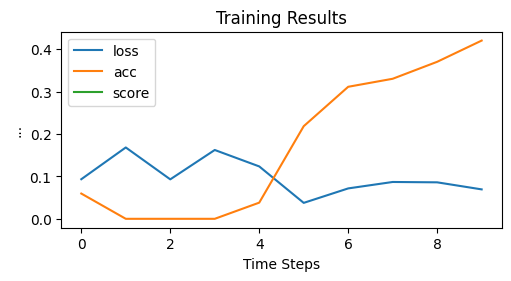

In [10]:
plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(loss_hist, label='loss')
plt.plot(acc_hist, label='acc')
plt.plot(score_hist, label='score')
plt.xlabel('Time Steps')
plt.ylabel('...')
plt.title("Training Results")
plt.legend()

### Loading a saved model
This section is will set the params of our agent to match out best_model.\
If we intend to run and save a new model, we should update the FILE var above as not to overwrite an existing model.\
There are 4 models on file:
 - **'./models/DQN_mountain_car.pth'** - *Scores(500-650)*
 - **'./models/DQN_mountain_car(2).pth'** - *Scores(May not even complete)*
 - **'./models/DQN_mountain_car(3).pth'** - *Scores(650-800)*
 - **'./models/DQN_mountain_car(x).pth'** - *The Working File*

In [15]:
agent.local_network.load_state_dict(torch.load(FILE)['local_network'])
agent.local_network.eval()
agent.target_network.load_state_dict(torch.load(FILE)['target_network'])
agent.target_network.eval()

Network(
  (fc1): Linear(in_features=2, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=1228, bias=True)
  (fc3): Linear(in_features=1228, out_features=1228, bias=True)
  (fc4): Linear(in_features=1228, out_features=640, bias=True)
  (fc5): Linear(in_features=640, out_features=3, bias=True)
)

### Test Agent And Visualize Results
In this section there really isn't much to cover.
Just know that all training and learning methods have been removed.\
Only a 10% of a weighted random event remain.

In [16]:
env = gym.make("MountainCar-v0", render_mode='human') # render_mode='human' will display the environment so we can watch

for i in range(1,5):
    terminated = False
    state,_ = env.reset()
    score = 1000

    while(not terminated and score > 0):
        action = agent.act(state, .01)
        next_state, reward, terminated,_,_ = env.step(action)

        state = next_state
        score += reward
    print(f'Episode:{i}\tScore: {score}')
env.close()

Episode:1	Score: 723.0
Episode:2	Score: 709.0
Episode:3	Score: 702.0
Episode:4	Score: 789.0
